In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(50, 145, 96)

df = pd.read_csv('2017-03-16_PRO_multi_well_inference_input_multi_well_t_50.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)
centred_moment_5 = moment(org_values, moment=5, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((96,5))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)
out_array[:,4] = np.divide(centred_moment_5,st_dev*st_dev*st_dev*st_dev*st_dev)

print(st_dev)

print(np.mean(org_values, axis=1))
print(centred_moment_3)

# print(centred_moments.shape)


[15.4219608  15.8269359  15.11067503 15.64338838 14.10901839 15.53534277
 15.8091619  14.17992948 15.35479078 14.74019929 14.24164316 14.78246935
 14.1964573  14.07045131 14.07892396 14.06163131 13.94908151 13.44175956
 13.4986629  13.30276193 13.87695932 13.12284649 11.60885007 12.24704454
 11.89526797 12.06114008 11.64801593 11.69198443 11.57082106 11.31704909
 10.94109112 11.44934387 10.65208313 11.21911761 10.49744135 10.45737061
 10.17435379 10.16638948 10.20910868  9.88020622  9.31039204  9.33741265
  8.94561904  8.85625626  8.3231965   8.40701493  8.32745309  8.07139393
  7.9086203   7.8493694   7.38126683  7.34848794  7.09366619  7.02135849
  6.46764834  6.65210305  6.55305272  6.44021739  6.43637126  6.16628738
  5.83888688  5.84065707  5.76935655  5.73429159  5.44024586  5.25952469
  5.21578374  5.2681567   5.27697593  4.74725184  4.64963439  4.79335738
  4.52603579  4.45772083  4.20648012  4.20871417  4.13906692  4.1184797
  4.05436801  3.70545544  3.74825293  3.61629645  3.

Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 5
noise_value = 25
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
noise_arr[0] = 1
noise_arr[1] = 1
noise_arr[2] = 1
noise_arr[3] = 1
noise_arr[4] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 7


Create uniform log prior

In [5]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.000001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 100
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_85287/1562655438.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.4
1     525     0:01.5
2     1008    0:02.6
3     1536    0:03.9
20    9153    0:21.8
40    16464   0:39.9
60    23145   0:57.0
80    29562   1:13.4
100   36186   1:29.7
120   42702   1:46.0
140   49509   2:03.0
160   55968   2:19.1
180   62571   2:35.5
200   69297   2:52.6
220   76089   3:09.9
240   82773   3:26.8
260   89478   3:43.9
280   96243   4:01.4
300   102783   4:18.0
320   109212   4:34.4
340   116004   4:51.9
360   122634   5:09.2
380   128994   5:25.4
400   135717   5:42.4
420   142548   6:00.1
440   149307   6:17.3
460   156039   6:34.5
480   162528   6:51.3
500   169089   7:07.9
520   175983   7:26.0
540   182466   7:42.3
560   189366   8:00.0
580   196209   8:18.2
600   202797   8:36.0
620   209604   8:53.8
640   216591   9:12.3
660   223284   9:30.0
680   229965   9:48.5
700   236691  10:07.5
720   243336  10:27.6
740   249639  10:48.5
760   256230  

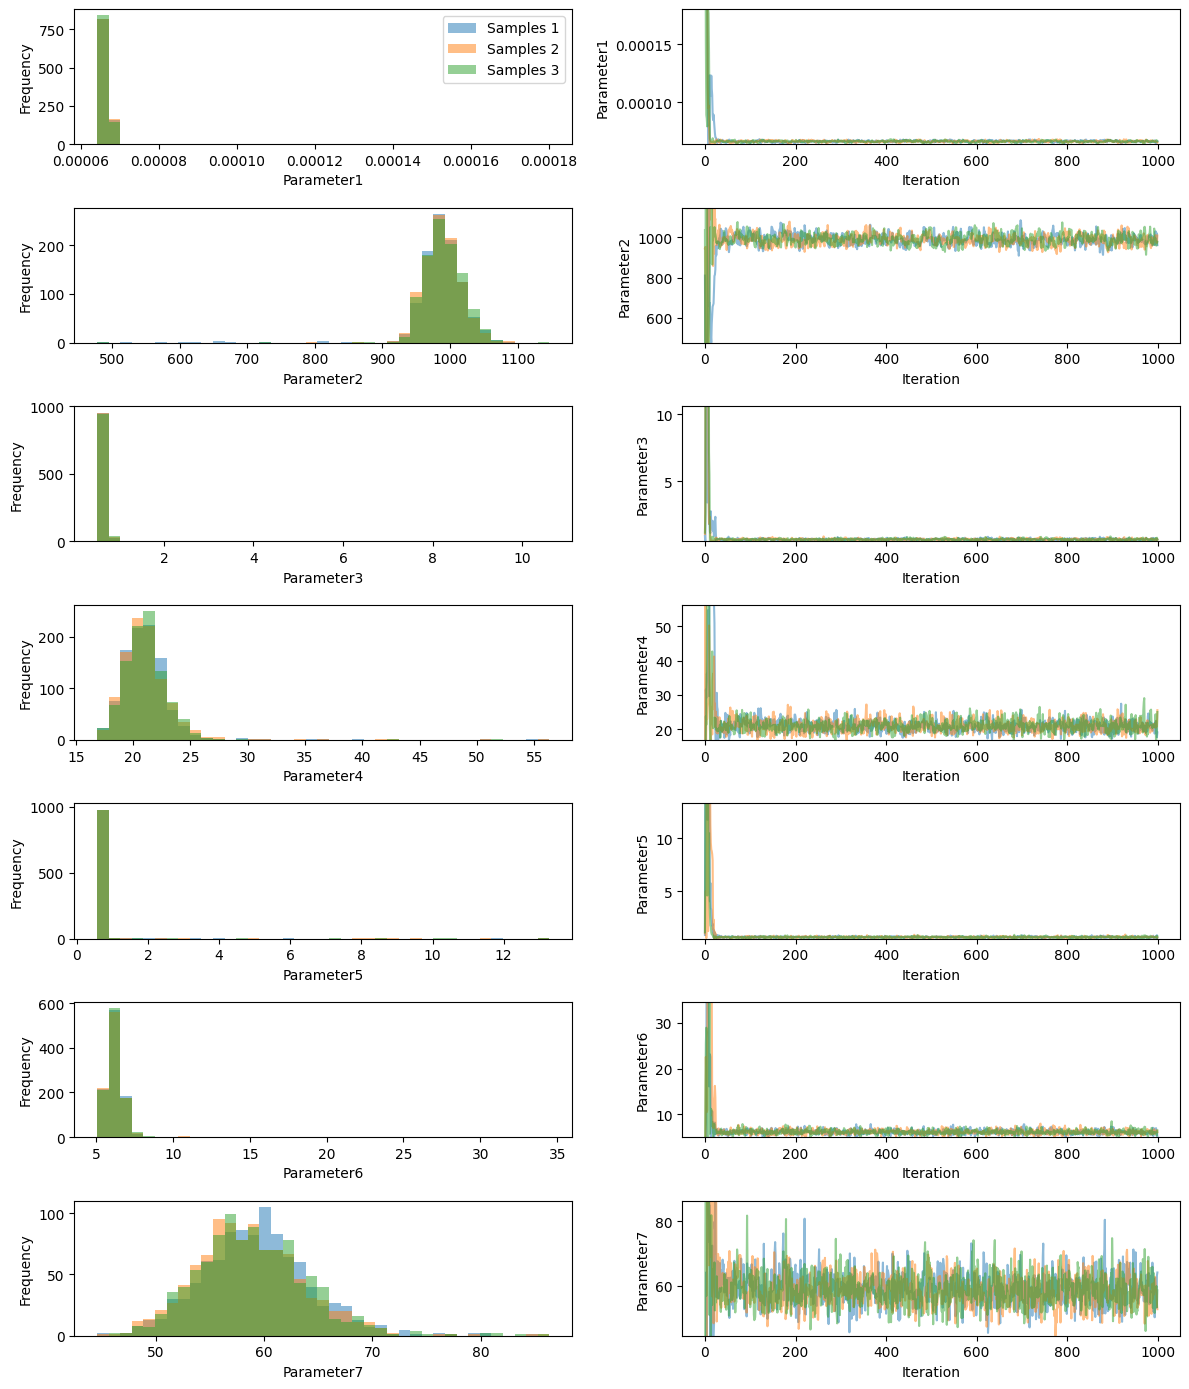

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()

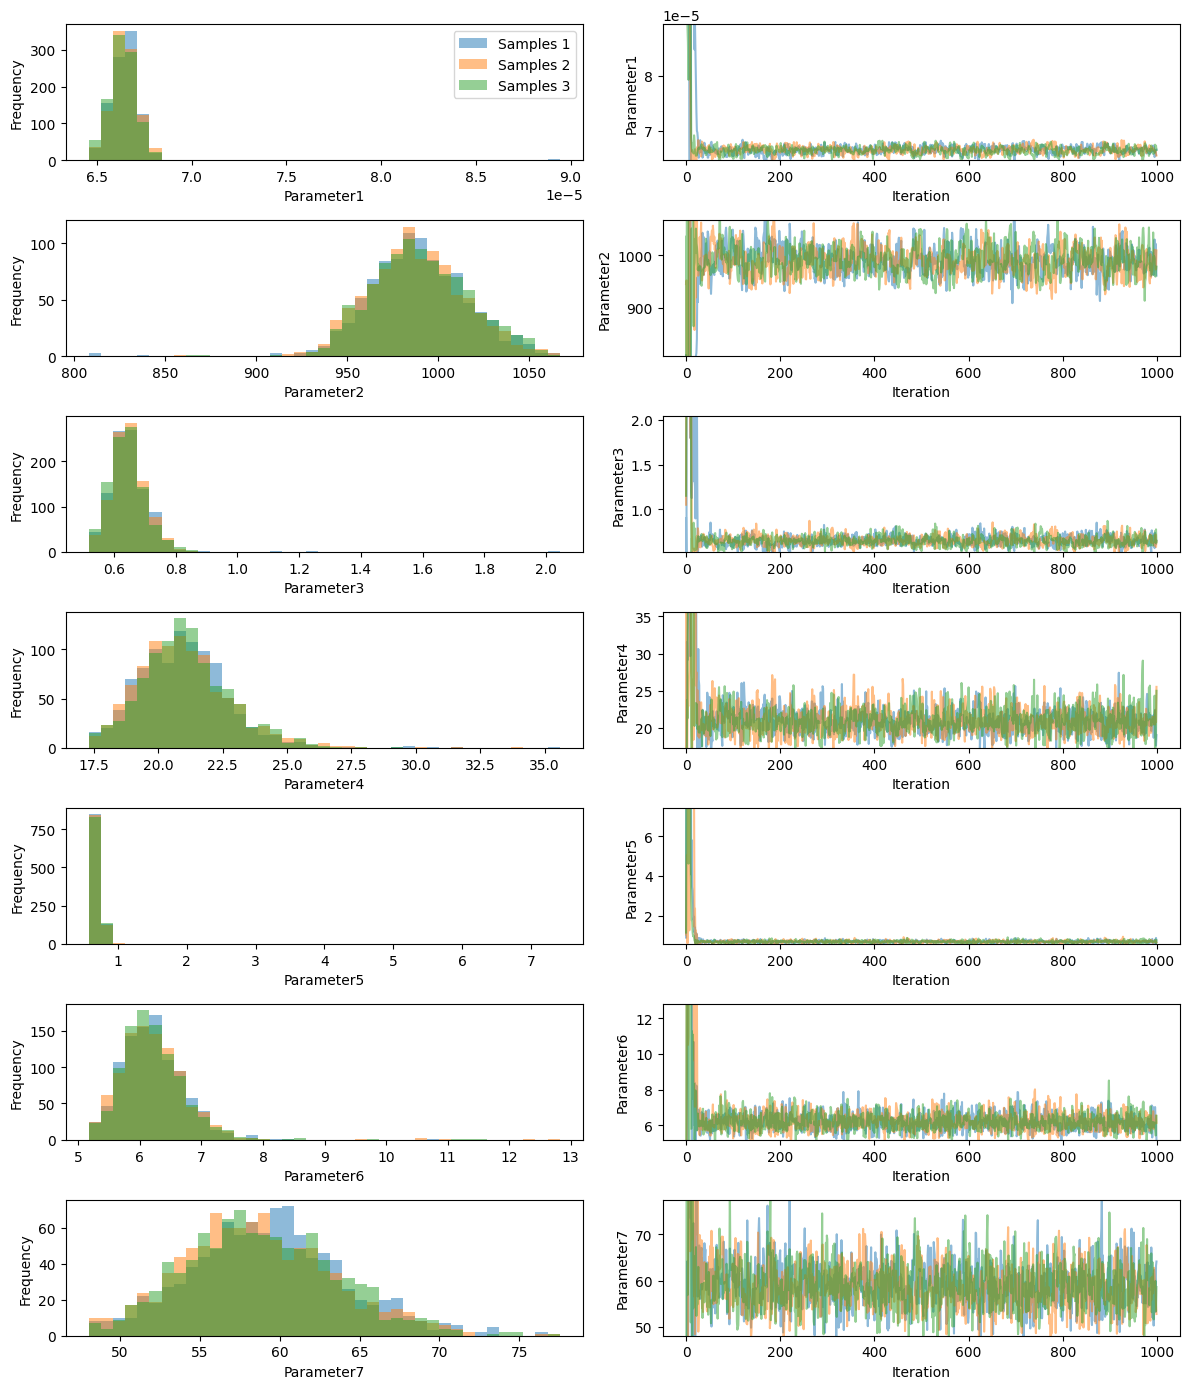

In [19]:
pints.plot.trace(chains, n_percentiles=98)
plt.savefig("mcmc.png")
plt.show()


In [8]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 7)
[6.61884853e-05 1.03655533e+03 5.67462133e-01 2.13905550e+01
 7.73852650e-01 6.08098631e+00 6.36498128e+01]
[[6.61884853e-05 1.03655533e+03 5.67462133e-01 ... 7.73852650e-01
  6.08098631e+00 6.36498128e+01]
 [6.53226858e-05 9.89177138e+02 6.60263314e-01 ... 6.94671045e-01
  6.80556207e+00 5.96888347e+01]
 [6.66931319e-05 9.81976026e+02 5.93765339e-01 ... 6.46561361e-01
  5.36110045e+00 6.41295868e+01]
 ...
 [6.53658215e-05 1.02182341e+03 6.01705906e-01 ... 5.52265902e-01
  6.38289761e+00 5.31986361e+01]
 [6.64923602e-05 9.82447593e+02 6.26219599e-01 ... 8.79533221e-01
  5.93423299e+00 6.32254266e+01]
 [6.65023896e-05 9.61150016e+02 6.46823550e-01 ... 6.64881907e-01
  5.17800162e+00 6.41483455e+01]]


In [9]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


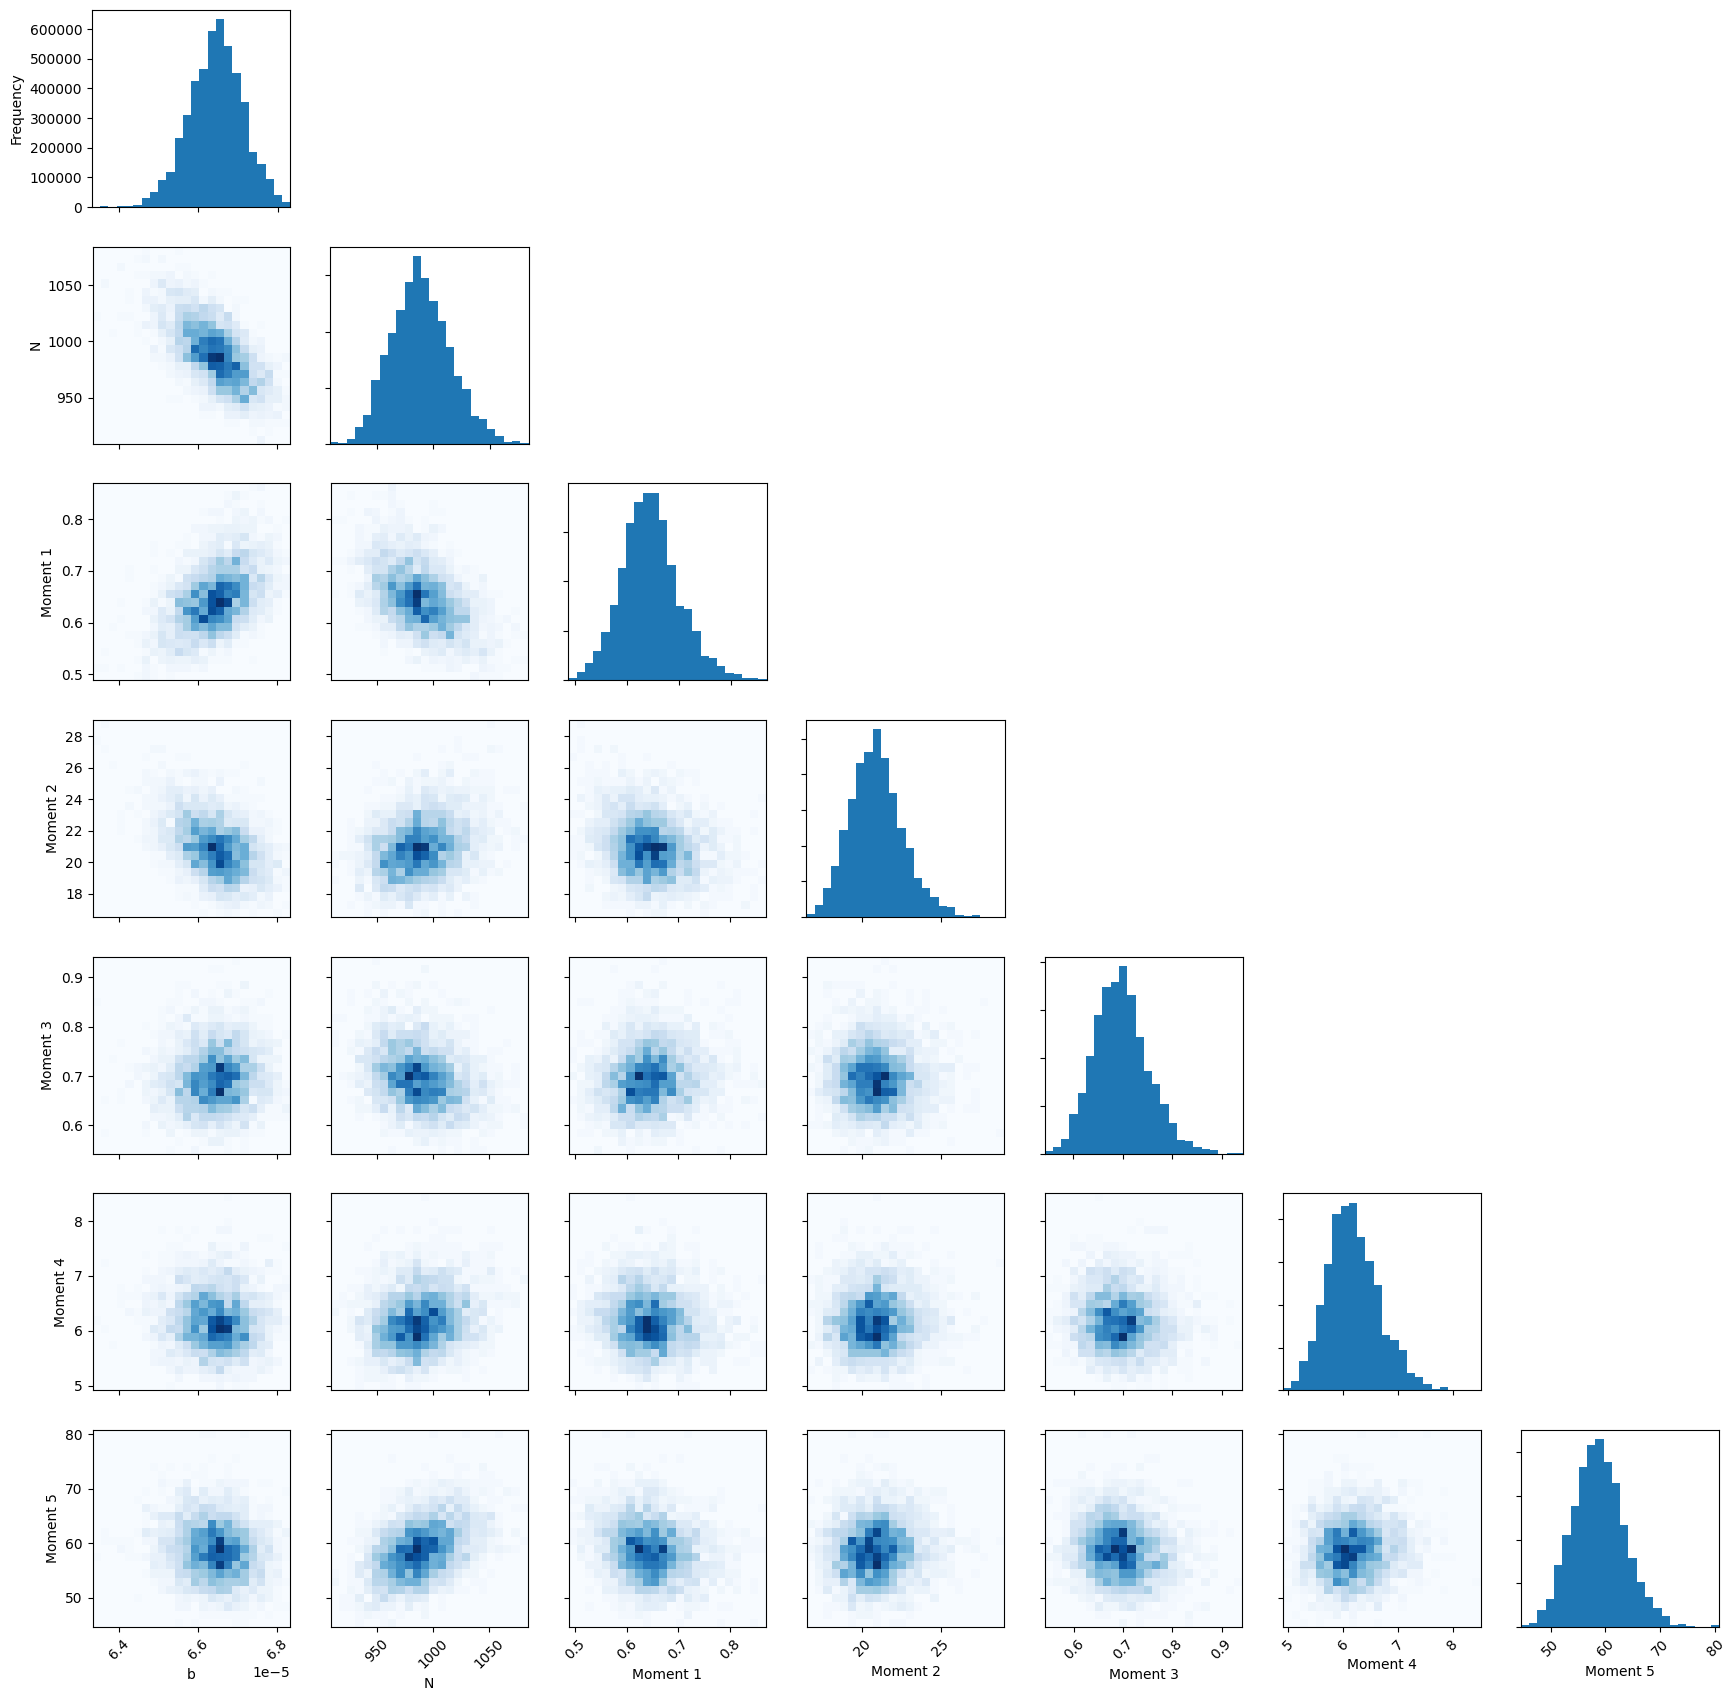

In [10]:


parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"])
plt.show()

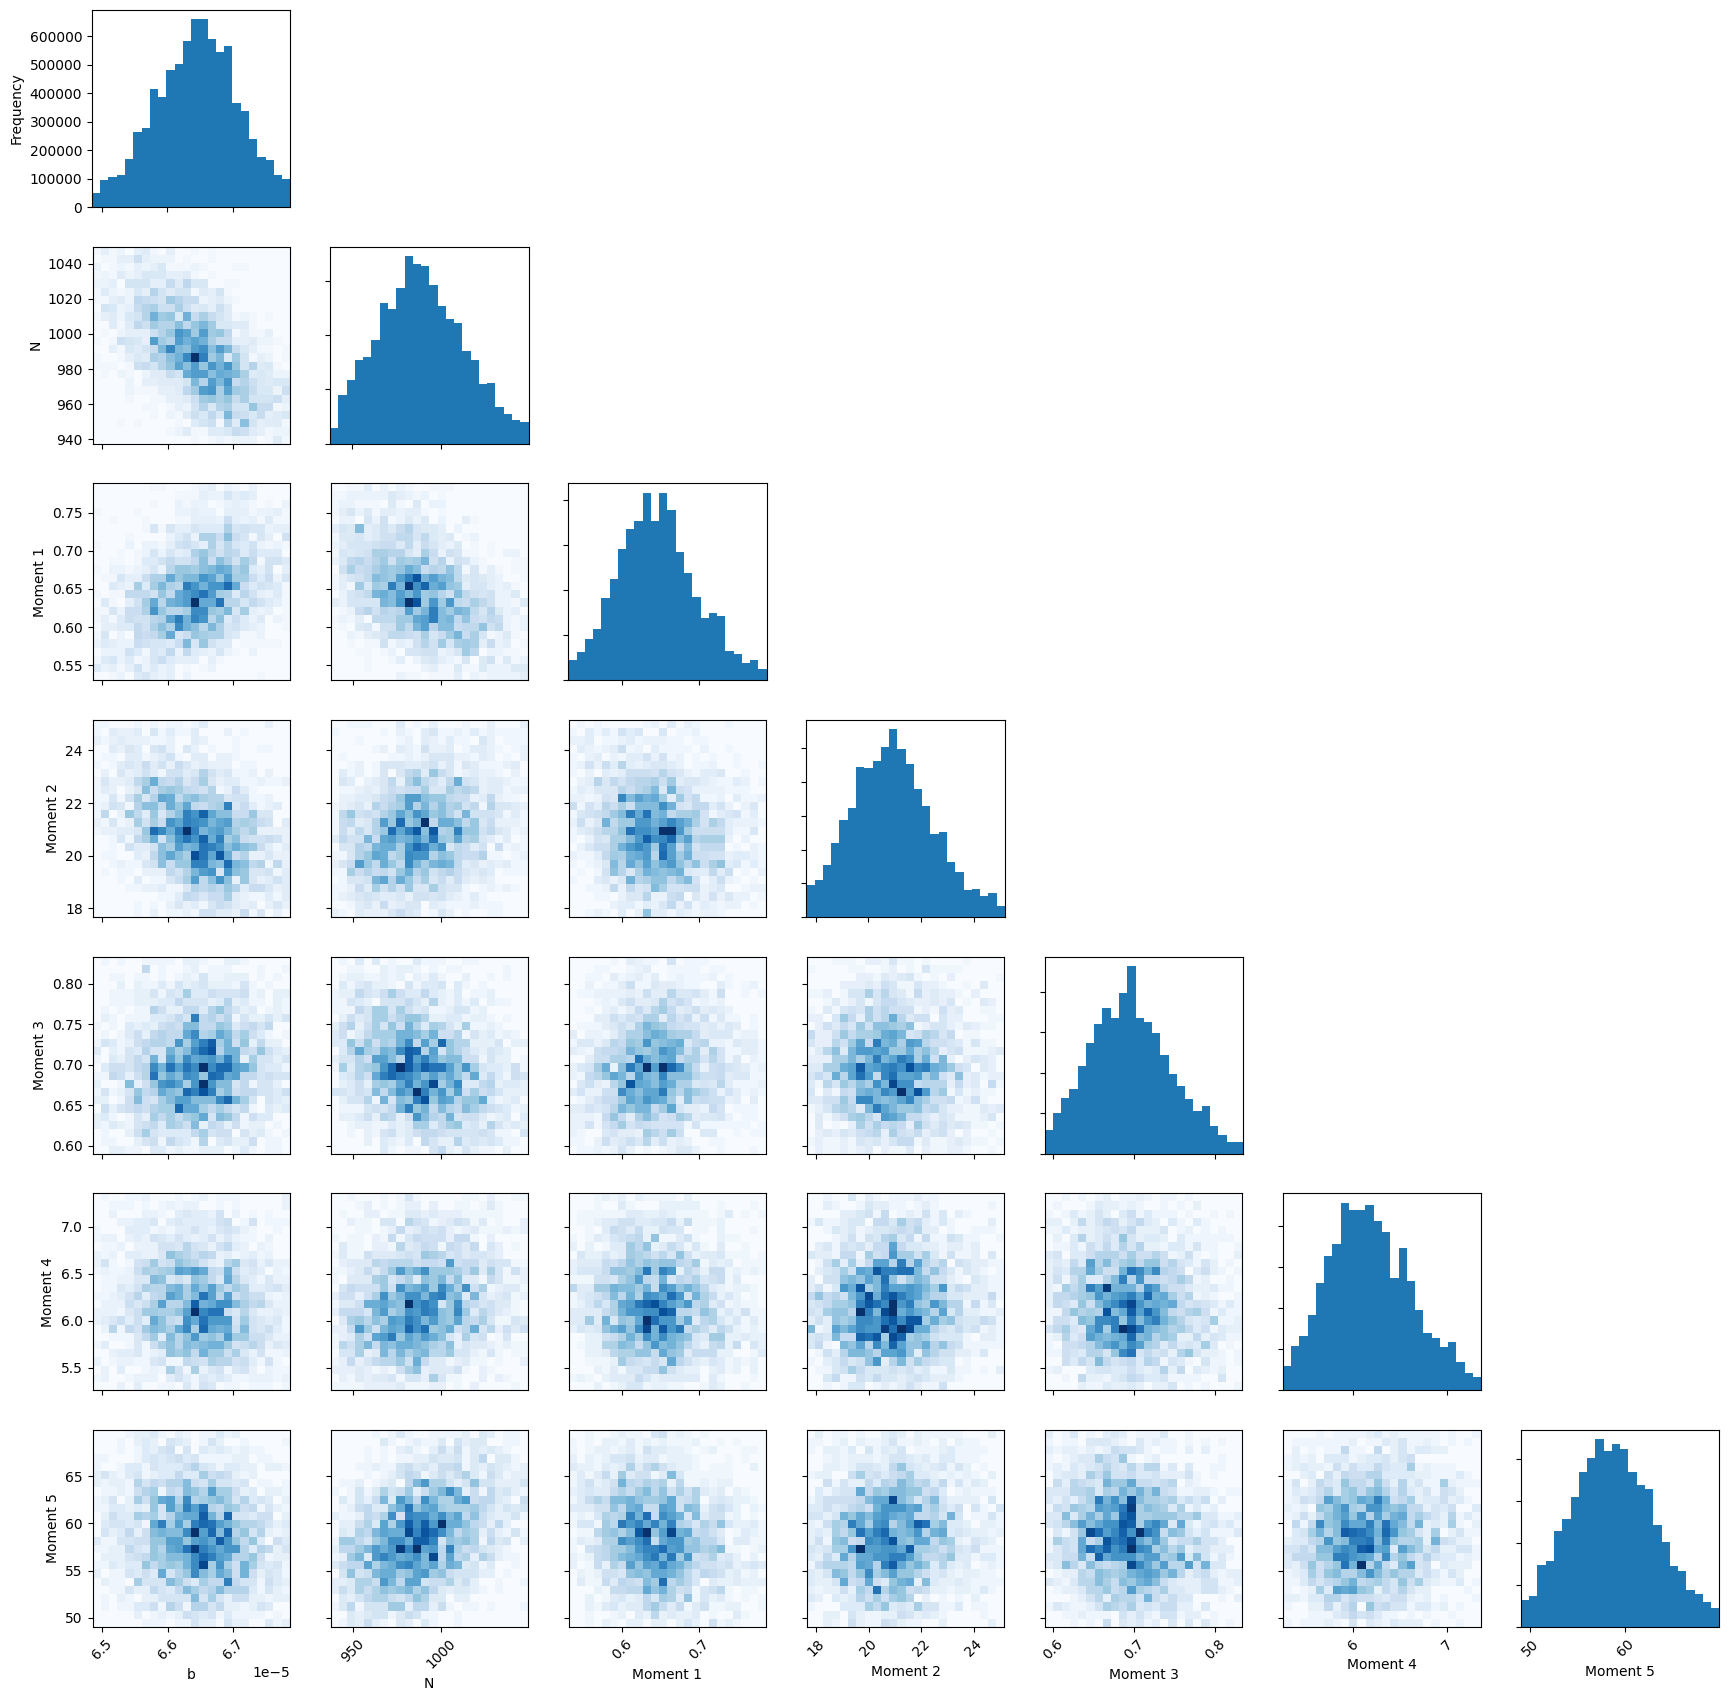

In [11]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"],
                    n_percentiles=97)
                    
plt.show()

[6.61884853e-05 1.03655533e+03 5.67462133e-01 2.13905550e+01
 7.73852650e-01 6.08098631e+00 6.36498128e+01]


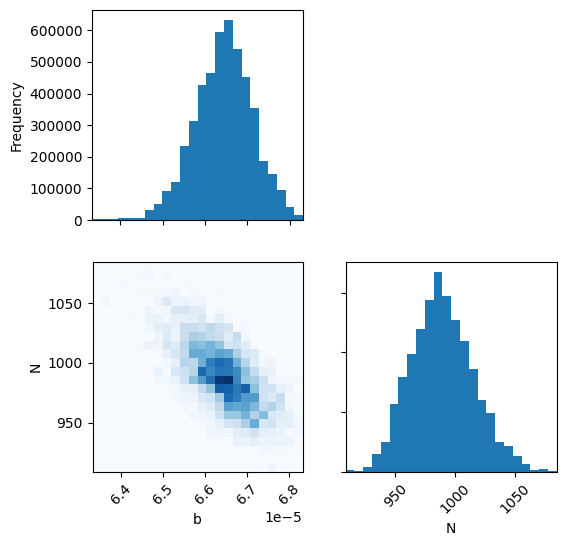

In [12]:
parameter_names = ["b","N"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1]], heatmap=True, 
                    parameter_names=["b","N"])
plt.savefig("Pints_pairwise_pro_params_only.png", dpi =300)
plt.show()


In [13]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean    std.    2.5%    25%     50%     75%      97.5%    rhat    ess     ess per sec.
--------  ------  ------  ------  ------  ------  -------  -------  ------  ------  --------------
b         0.00    0.00    0.00    0.00    0.00    0.00     0.00     1.01    254.78  0.28
N         987.80  26.28   941.14  969.56  986.11  1004.87  1044.61  1.00    262.48  0.29
Moment 1  0.65    0.06    0.54    0.61    0.64    0.68     0.78     1.00    343.09  0.38
Moment 2  20.95   1.70    17.90   19.78   20.86   21.90    24.68    1.01    400.33  0.45
Moment 3  0.70    0.06    0.60    0.66    0.69    0.73     0.82     1.00    444.15  0.50
Moment 4  6.18    0.48    5.37    5.85    6.13    6.48     7.25     1.00    467.16  0.52
Moment 5  58.60   4.77    49.63   55.35   58.46   61.73    68.42    1.00    388.59  0.43


In [14]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [15]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%     25%      50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  -------  -------  --------  --------  --------  ------  -----  --------------
b         6.65e-05  6.86e-07  6.5e-05  6.6e-05  6.65e-05  6.69e-05  6.78e-05  1.01    255    0.284
N         988       26.3      941      970      986       1e+03     1.04e+03  1       262    0.293
Moment 1  0.648     0.0592    0.54     0.608    0.645     0.681     0.778     1       343    0.382
Moment 2  20.9      1.7       17.9     19.8     20.9      21.9      24.7      1.01    400    0.446
Moment 3  0.698     0.0558    0.6      0.661    0.694     0.731     0.825     0.999   444    0.495
Moment 4  6.18      0.479     5.37     5.85     6.13      6.48      7.25      1       467    0.521
Moment 5  58.6      4.77      49.6     55.3     58.5      61.7      68.4      1       389    0.433


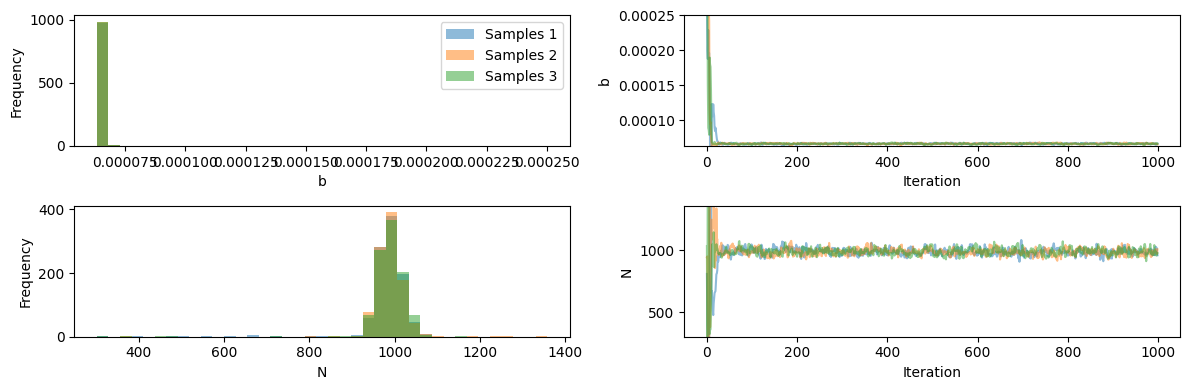

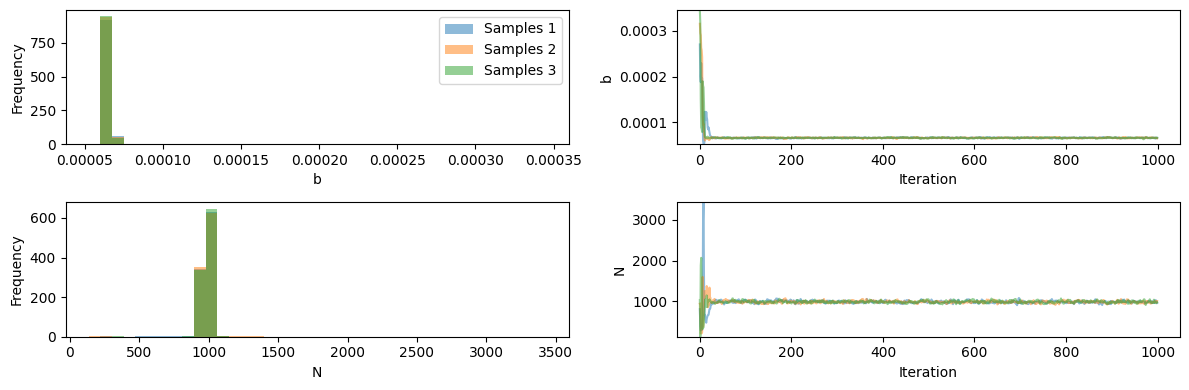

In [16]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()